In [3]:
import tensorflow as tf
from keras.src.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from history import plot_history, save_history
import tensorflow_datasets as tfds

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import tensorflow_datasets as tfds
# Load the cassava dataset

BATCH_SIZE = 32

training_ds, info = tfds.load('cassava', with_info=True, as_supervised=True, split='train')
test_ds = tfds.load('cassava', as_supervised=True, split='test')
validation_ds = tfds.load('cassava', as_supervised=True, split='validation')

# Define data augmentation operations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Apply data augmentation
def augment_training(image, label):
    image = data_augmentation(image)
    image = tf.image.resize(image, (500, 500))
    label = tf.one_hot(label, 3)  # One-hot encode the labels
    return image, label

rescale_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

def augment_rescale(image, label):
    image = rescale_augmentation(image)
    image = tf.image.resize(image, (500, 500))
    label = tf.one_hot(label, 3)  # One-hot encode the labels
    return image, label

training_augmented = training_ds.map(augment_training)
test_augmented = test_ds.map(augment_rescale)
validation_augmented = validation_ds.map(augment_rescale)


training_augmented = training_augmented.batch(BATCH_SIZE)
test_augmented = test_augmented.batch(BATCH_SIZE)
validation_augmented = validation_augmented.batch(BATCH_SIZE)



In [66]:
def compile_model(model: tf.keras.Sequential):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [89]:
def create_model():
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((500, 500, 3)),
        # tf.keras.layers.experimental.preprocessing.Resizing(125, 125),
        # tf.keras.layers.Conv2D(64, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Conv2D(128, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Conv2D(128, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return compile_model(new_model)

In [90]:
def save_model(model, name, history, test_data):
    test_loss, test_acc = model.evaluate(test_data)

    # Save model information
    save_name = f'models/ibeans/{name}-{len(history.epoch):02d}-{test_acc:0.4f}'
    model.save(f'{save_name}.h5')

    # Save history information
    save_history(history, save_name)

In [104]:
model = create_model()

model_name = 'cassava-01'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'ckpts/cassava/{model_name}-'+'{epoch:02d}-{val_accuracy:.4f}')

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 750000)            0         
                                                                 
 dense_38 (Dense)            (None, 128)               96000128  
                                                                 
 dense_39 (Dense)            (None, 3)                 387       
                                                                 
Total params: 96000515 (366.21 MB)
Trainable params: 96000515 (366.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [106]:
history = model.fit(training_augmented, epochs=1, validation_data=validation_augmented , callbacks=[checkpoint])

177/177 [==============================] - ETA: 0s - loss: 153.5020 - accuracy: 0.2961INFO:tensorflow:Assets written to: ckpts/cassava/cassava-01-01-0.2552/assets


INFO:tensorflow:Assets written to: ckpts/cassava/cassava-01-01-0.2552/assets


177/177 [==============================] - 79s 441ms/step - loss: 153.5020 - accuracy: 0.2961 - val_loss: 345.1518 - val_accuracy: 0.2552


In [108]:
def save_model(model, name, history, test_data):
    test_loss, test_acc = model.evaluate(test_data)

    # Save model information
    save_name = f'models/cassava/{name}-{len(history.epoch):02d}-{test_acc:0.4f}'
    model.save(f'{save_name}.tf')

    # Save history information
    save_history(history, save_name)
    
save_model(model, 'cassava-01', history, test_augmented)


59/59 [==============================] - 3s 46ms/step - loss: 347.2133 - accuracy: 0.2552
INFO:tensorflow:Assets written to: models/cassava/cassava-01-01-0.2552.tf/assets


INFO:tensorflow:Assets written to: models/cassava/cassava-01-01-0.2552.tf/assets


In [7]:
from history import load_history
history_old = load_history('models/cassava/cassava-01-01-0.3252', model_format='.h5')


In [8]:
# load model from checkpoint
from tensorflow import keras
import tensorflow as tf

# get model from history
old_model = tf.keras.models.load_model('ckpts/cassava/cassava-01-01-0.2552')


In [5]:


# train model staring with epoch 5 for another 10 epochs
history_new = old_model.fit(training_augmented, validation_data=validation_augmented, epochs=2, initial_epoch=1)

Epoch 2/2
177/177 [==============================] - 75s 421ms/step - loss: 243.4014 - accuracy: 0.3006 - val_loss: 75.1443 - val_accuracy: 0.2107


In [9]:
%load_ext autoreload
# append history
from history import add_history
extended_history = add_history(history_old, history_new)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


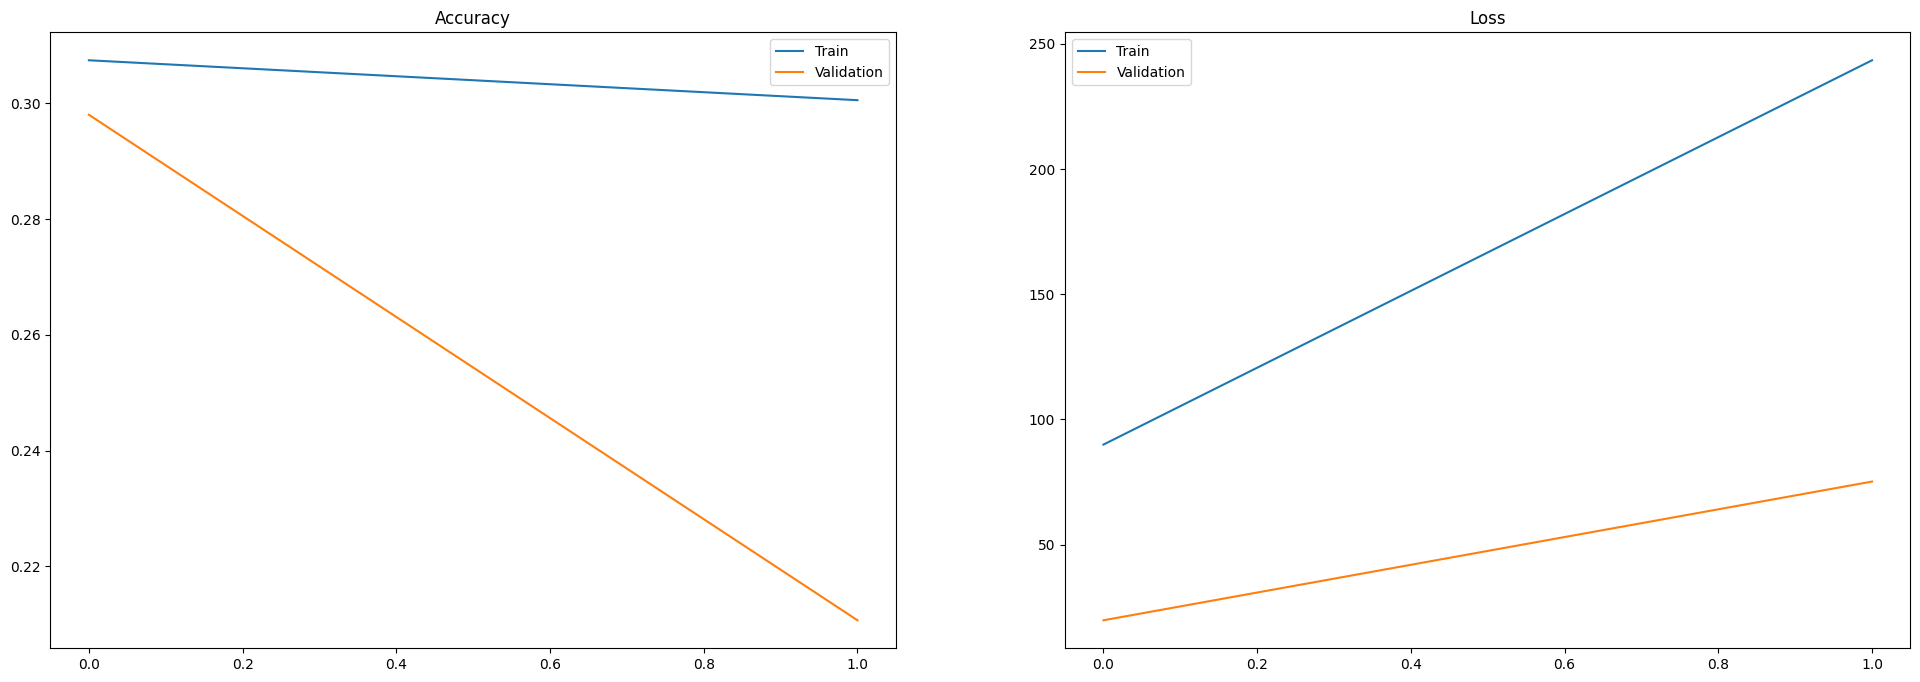

In [10]:
from history import plot_history
plot_history(extended_history)

In [12]:
len(extended_history.epoch)


2